In [1]:
import h5py
import numpy as np
import scipy.signal
from scipy.signal import welch,  iirnotch, filtfilt
import matplotlib.pyplot as plt
import os


In [2]:
# Notebook default: force white background for all matplotlib figures/axes and saved files
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['savefig.facecolor'] = 'white'
mpl.rcParams['figure.edgecolor'] = 'white'
# Use default style to avoid dark seaborn or theme overrides
mpl.style.use('default')
print('Matplotlib defaults set: figure/axes/savefig facecolor = white')

Matplotlib defaults set: figure/axes/savefig facecolor = white


In [3]:
def open_hdf5_file(file_path, dataset_name, mode='r'):
    hdf5_file = h5py.File(file_path, mode)
    if dataset_name in hdf5_file:
        dataset = hdf5_file[dataset_name]
    else:
        raise ValueError(f"Dataset '{dataset_name}' not found in the file.")
    return hdf5_file, dataset

def bandpower_ratio(signal, fs, low=20, high=450):
    f, Pxx = welch(signal, fs=fs, nperseg=1024)
    total_power = np.trapz(Pxx, f)
    emg_power = np.trapz(Pxx[(f >= low) & (f <= high)], f[(f >= low) & (f <= high)])
    return emg_power / total_power
def notch_filter(data, fs, f0, Q=30.0):
    b, a = iirnotch(f0, Q, fs)
    return filtfilt(b, a, data)

def remove_odd_harmonics(data, fs, f0=50.0, harmonics=5, Q=30.0):
    filtered_data = data
    for k in range(1, harmonics + 1, 2):  # Only odd harmonics (1, 3, 5, ...)
        harmonic_freq = f0 * k
        if harmonic_freq < fs / 2:  # Ensure it is within Nyquist frequency
            filtered_data = notch_filter(filtered_data, fs, harmonic_freq, Q)
    return filtered_data

def remove_harmonics(data, fs, f0=50.0, harmonics=5, Q=30.0):
    filtered_data = data
    for k in range(1, harmonics + 1):  # Only odd harmonics (1, 3, 5, ...)
        harmonic_freq = f0 * k
        if harmonic_freq < fs / 2:  # Ensure it is within Nyquist frequency
            filtered_data = notch_filter(filtered_data, fs, harmonic_freq, Q)
    return filtered_data

def feed_forward_comb_filter(signal, delay, alpha):
    """
    Apply a feed-forward comb filter to the input signal.
    Parameters:
    signal (numpy.ndarray): Input EMG signal.
    delay (int): Delay in samples. fs/freq
    alpha (float): Feedback gain factor. -1
    Returns:
    numpy.ndarray: Filtered signal.
    """
    # Initialize the output array with the same length as the input signal
    filtered_signal = np.zeros_like(signal)
    # Apply the comb filter
    for n in range(len(signal)):
        if n >= delay:
            filtered_signal[n] = signal[n] + alpha * signal[n - delay]
        else:
            filtered_signal[n] = signal[n]  # No delay possible for the initial samples
    return filtered_signal

def butter_highpass(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = scipy.signal.butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = scipy.signal.filtfilt(b, a, data)
    return filtered_data

def butter_lowpass(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = scipy.signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = scipy.signal.filtfilt(b, a, data)
    return filtered_data

In [4]:
#file_path = r'C:\Users\rp02\Desktop\Null_Space_EMG\PT_07\PT_07_Day1\Coin_Task\Raw_emg_1.hdf5'  # Path to your HDF5 file
file_path = '/Users/rupshapanda/Desktop/Plasticity Lab/Null_Space_EMG/PT_07/PT_07_Day1/Coin_Task/Raw_emg_1.hdf5'  # Path to your HDF5 file
dataset_name = 'rawEMG'

hdf5_file, dataset = open_hdf5_file(file_path, dataset_name, mode='r')

data = np.array(dataset[:])
print(data.shape)

(120000, 64)


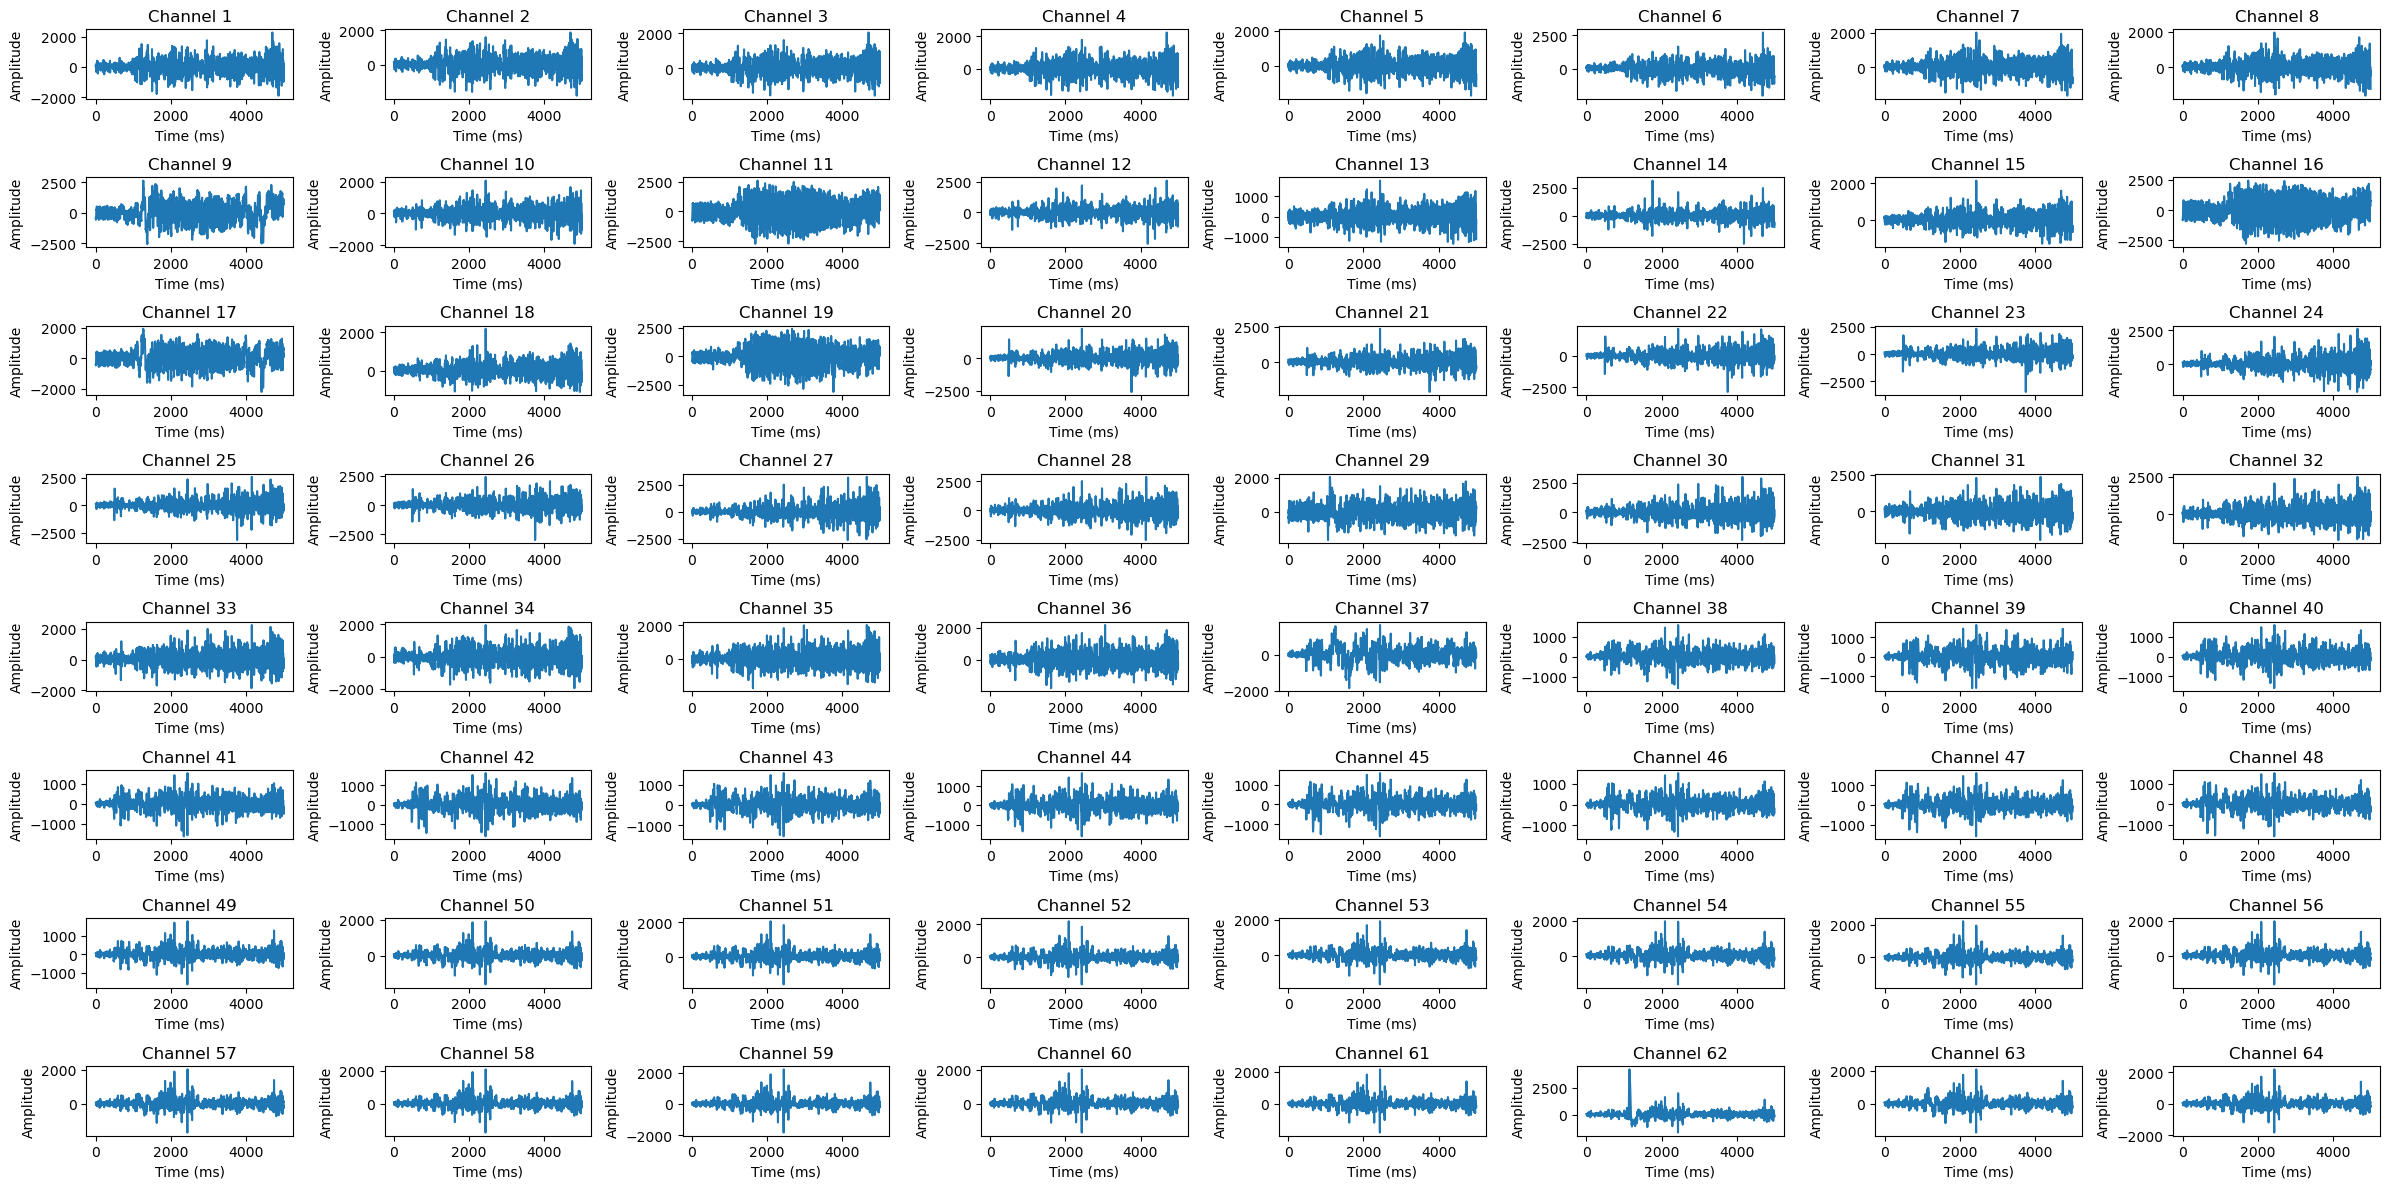

In [5]:
plt.figure(figsize=(24, 12))

for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    ax.plot(data[:5000, i])  # first 2.5 sec (5000 samples at 2kHz)
    ax.set_title(f'Channel {i+1}')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

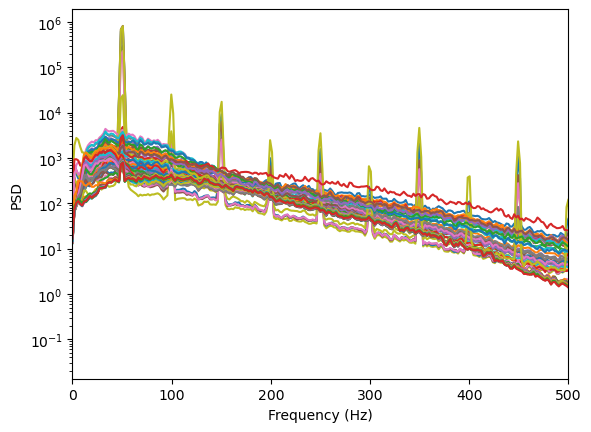

In [6]:
fs = 2000  # Hz
for i in range(64):
    f, Pxx = welch(data[:, i], fs=fs, nperseg=1024)
    plt.semilogy(f, Pxx)
    plt.xlim([0, 500])
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.show()

In [7]:
snr_estimates = [bandpower_ratio(data[:, i], fs) for i in range(64)]
print("Mean SNR estimate:", np.mean(snr_estimates))

Mean SNR estimate: 0.9370091380406562


In [8]:
rms_channels = np.sqrt(np.mean(data**2, axis=0))
print("RMS per channel:", rms_channels)

RMS per channel: [ 384.65048  356.32758  331.68268  364.54874  331.76816  389.7964
  333.27164  310.95023 1092.4219   316.9265  1706.3909   330.64996
  288.52676  336.0709   292.7896  1783.0701   966.5749   297.72052
 1834.0934   351.487    338.62576  409.2936   412.82095  447.27383
  480.73782  439.6659   568.7795   536.418    492.34152  554.49835
  518.7588   455.29095  487.26315  472.67148  420.50952  435.06003
  310.85992  272.10574  334.40604  305.55582  287.4173   333.32938
  292.09406  316.82288  294.38754  261.29865  282.87112  257.49344
  246.54869  252.78815  255.7699   267.25104  270.5295   258.50757
  265.55844  260.80905  259.89404  261.13007  265.55438  255.94081
  258.72614  261.15573  254.4393   256.64322]


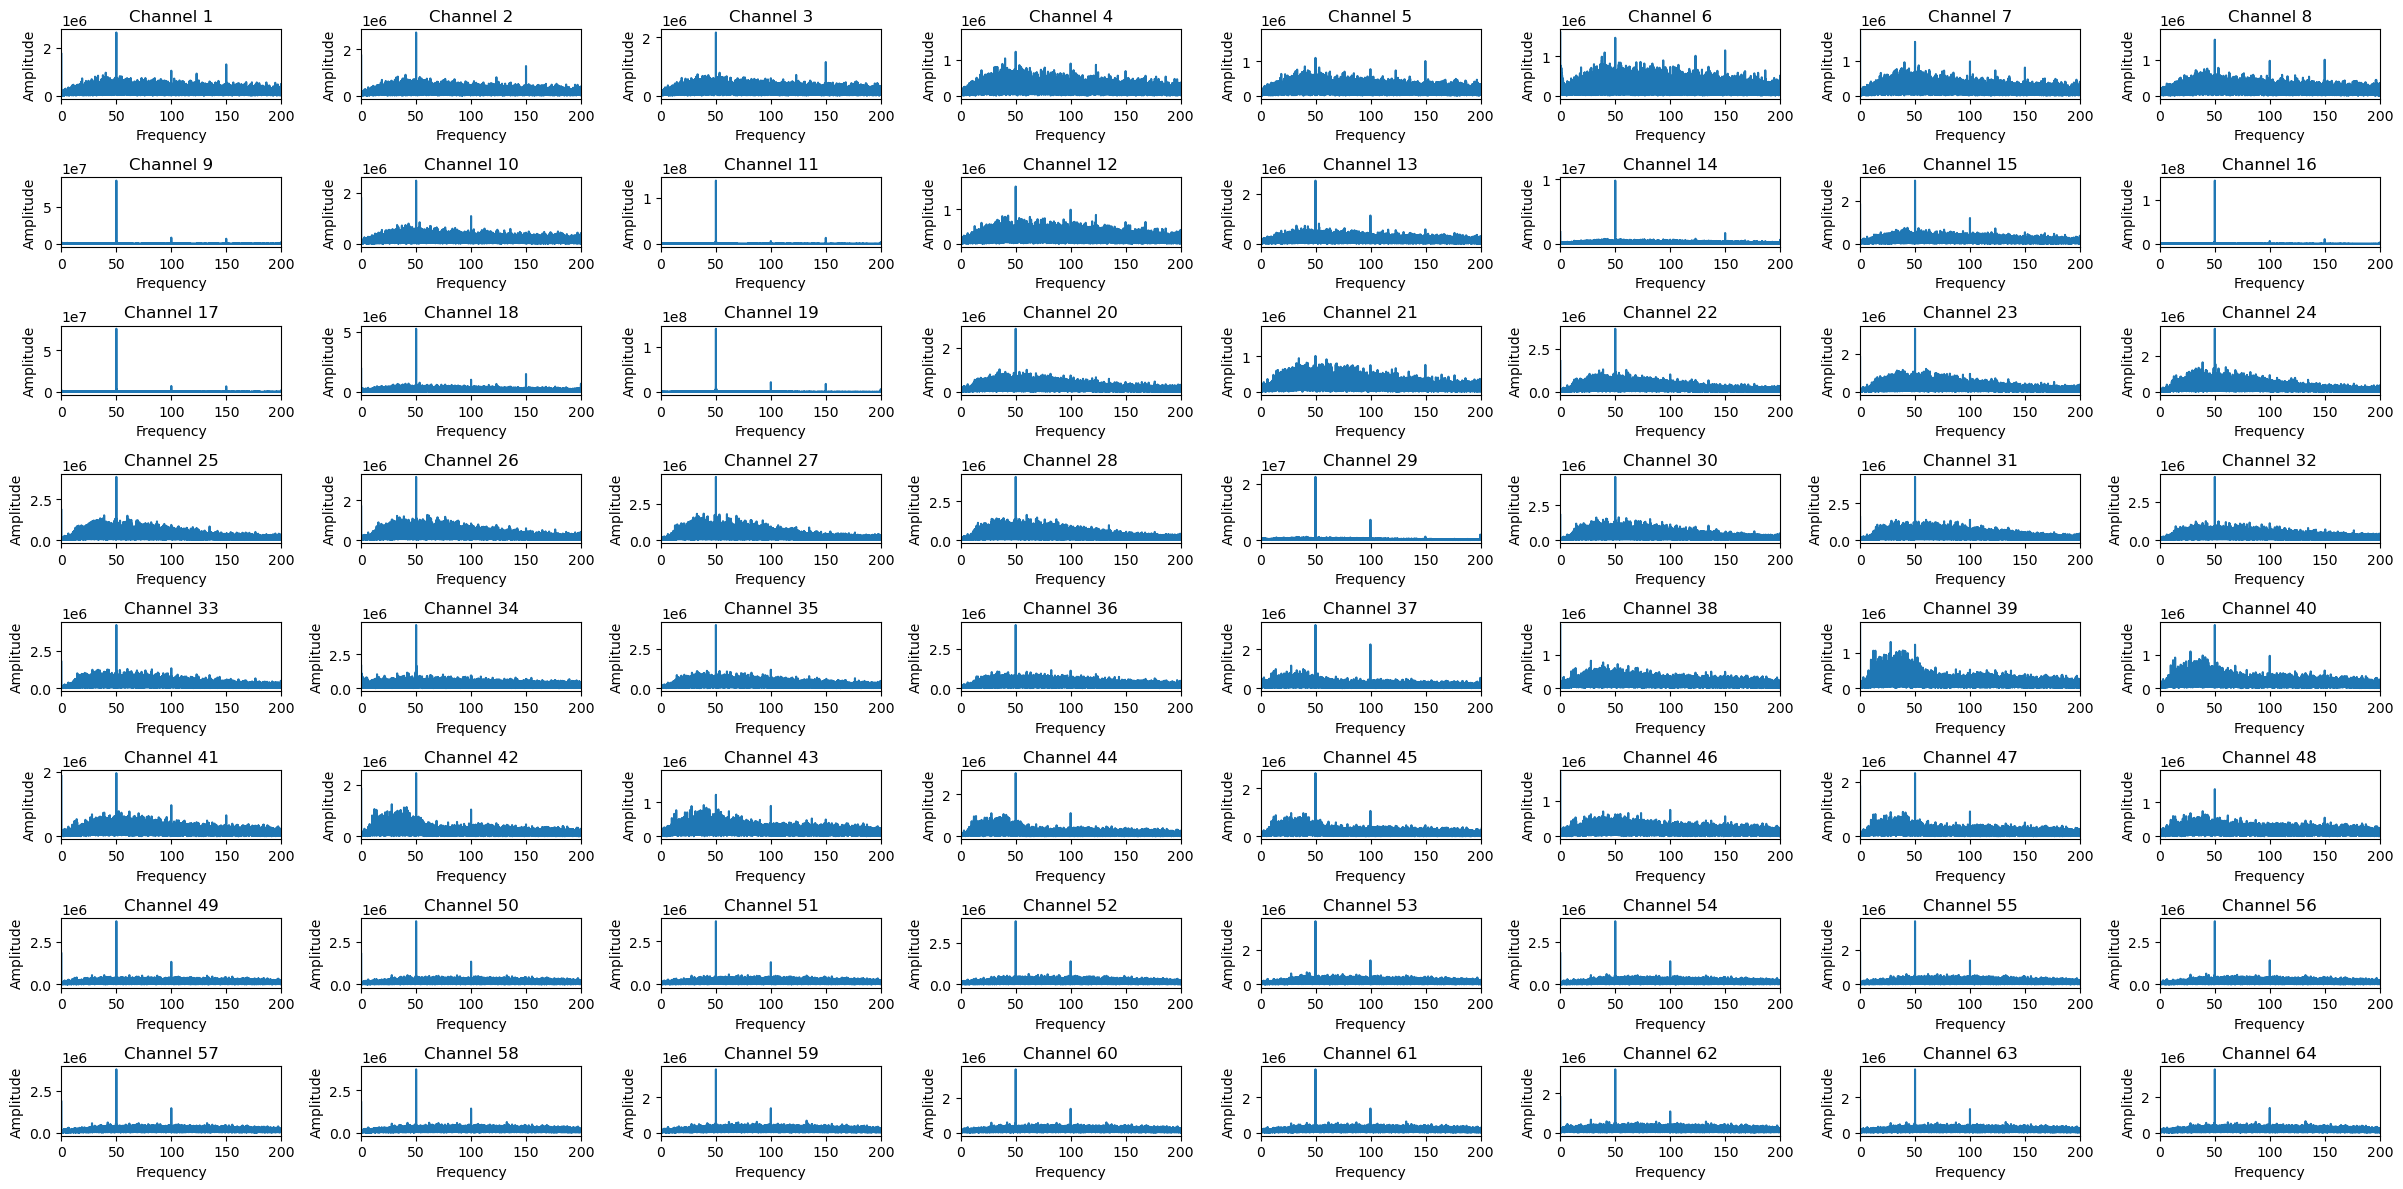

In [9]:
# plt.figure(figsize=(24, 12))
# for i, col_list in enumerate(column_lists):
#     ax = plt.subplot(8,8,i+1)
#     yf = np.fft.fft(col_list)
#     # yf = np.fft.fft(col_list)
#     # yf = np.fft.fft(col_list)
#     xf = np.fft.fftfreq(len(col_list), 1/2000)
#     ax.plot(xf, np.abs(yf))
#     #plt.plot(scipy_env_filter(feed_forward_comb_filter(col_list, delay, alpha), 217, emg_filters))
#     ax.set_title(f'Channel {i+1}')
#     ax.set_xlabel('Frequency')
#     ax.set_xlim(0,200)
#     ax.set_ylabel('Amplitude')
#     # ax.set_ylim(-1000000,1000000)
#     # for flag_value in flag_values:
#     #     plt.axvline(x=flag_value*2000, color='r', linestyle='--', linewidth=1)
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(24, 12))

for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    x_data = data[:, i]
    yf = np.fft.fft(x_data)
    xf = np.fft.fftfreq(len(x_data), 1/2000)
    ax.plot(xf, np.abs(yf))
    ax.set_title(f'Channel {i+1}')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Amplitude')
    ax.set_xlim(0,200)

plt.tight_layout()
plt.show()

In [10]:
x_data.shape

(120000,)

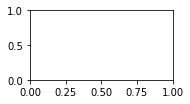

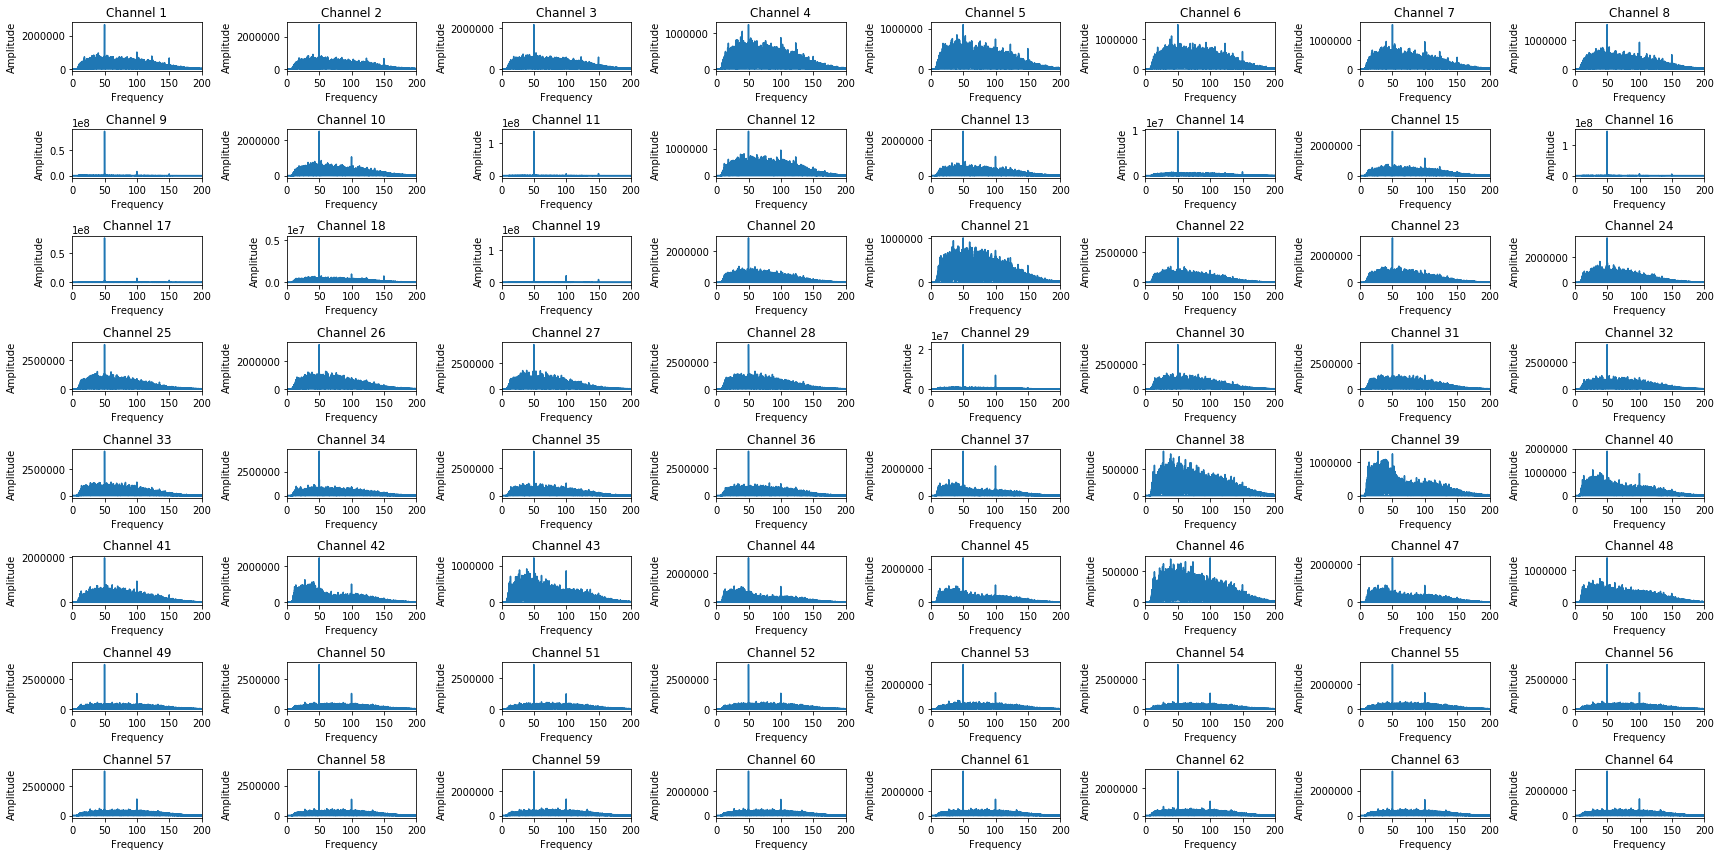

In [12]:
plt.figure(figsize=(24, 12))
freq = 50
delay = int(fs / freq)  # Delay to target the frequency of the sine wave
alpha = -1  # Feedback gain factor
for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    x_data = data[:, i]
    x_data = butter_highpass(x_data, 10, 2000) # 10 is the freq we're taking out over the 2000 hz signal
    x_data = butter_lowpass(x_data, 150, 2000)
    # data = feed_forward_comb_filter(data, delay, alpha)
    #x_data = remove_harmonics(x_data,2000)
    yf = np.fft.fft(x_data)
    xf = np.fft.fftfreq(len(x_data), 1/2000)
    ax.plot(xf, np.abs(yf))
    ax.set_title(f'Channel {i+1}')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Amplitude')
    ax.set_xlim(0,200)

plt.tight_layout()
plt.show()